In [2]:
from __future__ import division
from __future__ import print_function
import random

def randchoices(seq, k=10):
    return [random.choice(seq) for i in range(k)]

random.choices = randchoices

## The following are standard UNIX shell commands run inside of a Notebook Cell

In [3]:
!ls -l ./data

total 128
-rw-r--r--  1 owenmccadden  staff  30230 Jan 13 14:25 SARS-COV-2Omicron.fasta
-rw-r--r--  1 owenmccadden  staff  30499 Jan 13 14:30 SARS-COV-2Wuhan.fasta


In [4]:
!head ./data/SARS-COV-2Wuhan.fasta

>NC_045512.2 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCT
GTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACT
CACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATC
TTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTT
CGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAAC
ACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGG
AGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGG
CTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAA
ACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACT


In [5]:
!tail ./data/SARS-COV-2Wuhan.fasta

TATTGACGCATACAAAACATTCCCACCAACAGAGCCTAAAAAGGACAAAAAGAAGAAGGC
TGATGAAACTCAAGCCTTACCGCAGAGACAGAAGAAACAGCAAACTGTGACTCTTCTTCC
TGCTGCAGATTTGGATGATTTCTCCAAACAATTGCAACAATCCATGAGCAGTGCTGACTC
AACTCAGGCCTAAACTCATGCAGACCACACAAGGCAGATGGGCTATATAAACGTTTTCGC
TTTTCCGTTTACGATATATAGTCTACTCTTGTGCAGAATGAATTCTCGTAACTACATAGC
ACAAGTAGATGTAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGTAACATTA
GGGAGGACTTGAAAGAGCCACCACATTTTCACCGAGGCCACGCGGAGTACGATCGAGTGT
ACAGTGAACAATGCTAGGGAGAGCTGCCTATATGGAAGAGCCCTAATGTGTAAAATTAAT
TTTAGTAGTGCTATCCCCATGTGATTTTAATAGCTTCTTAGGAGAATGACAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAA

In [6]:
!wc ./data/*.fasta

     425     436   30230 ./data/SARS-COV-2Omicron.fasta
     499     510   30499 ./data/SARS-COV-2Wuhan.fasta
     924     946   60729 total


## Next we write and execute Python3 inside of a Notebook Cell

In [7]:
import gzip

def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into two lists. One of 
        headers and a second list of sequences.
        The ith index of each list correspond."""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # split at headers
    data = fp.read().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        # add an extra "+" to make string "1-referenced"
        sequences.append('+' + ''.join(lines))
    return (headers, sequences)

In [8]:
header, seq = loadFasta("./data/SARS-COV-2Wuhan.fasta")

for i in range(len(header)):
    print(header[i])
    print(len(seq[i])-1, "bases", seq[i][:30], "...", seq[i][-30:])
    print()

NC_045512.2 |Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
29903 bases +ATTAAAGGTTTATACCTTCCCAGGTAACA ... AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA



## Use *k*-mer profiles to study a DNA sequence

In [9]:
def kmerCounts(seq, k):
    kmerDict = {}
    for i in range(1,len(seq)-k+1):
        kmer = seq[i:i+k]
        kmerDict[kmer] = kmerDict.get(kmer,0) + 1
    return kmerDict

In [10]:
# Test code for the kmerCounts() function
print(kmerCounts("+TAGACAT",3))
print(kmerCounts("+missmississippi",3))

{'TAG': 1, 'AGA': 1, 'GAC': 1, 'ACA': 1, 'CAT': 1}
{'mis': 2, 'iss': 3, 'ssm': 1, 'smi': 1, 'ssi': 2, 'sis': 1, 'sip': 1, 'ipp': 1, 'ppi': 1}


In [11]:
print('  k     k-mers                       4^k      N-k+1                   missing   repeated')
for k in range(3,35):
    kmers = kmerCounts(seq[0], k)
    print("%3d %10d %25d %10d %25d %10d" % (k, len(kmers), 4**k, (len(seq[0])-1)-k+1, 4**k-len(kmers), (len(seq[0])-1)-k+1-len(kmers)))
    
    

  k     k-mers                       4^k      N-k+1                   missing   repeated
  3         64                        64      29901                         0      29837
  4        256                       256      29900                         0      29644
  5       1023                      1024      29899                         1      28876
  6       3756                      4096      29898                       340      26142
  7      10696                     16384      29897                      5688      19201
  8      20185                     65536      29896                     45351       9711
  9      26360                    262144      29895                    235784       3535
 10      28789                   1048576      29894                   1019787       1105
 11      29566                   4194304      29893                   4164738        327
 12      29777                  16777216      29892                  16747439        115
 13      29835       

## Examining k-mer distribution differences between real and random genomes

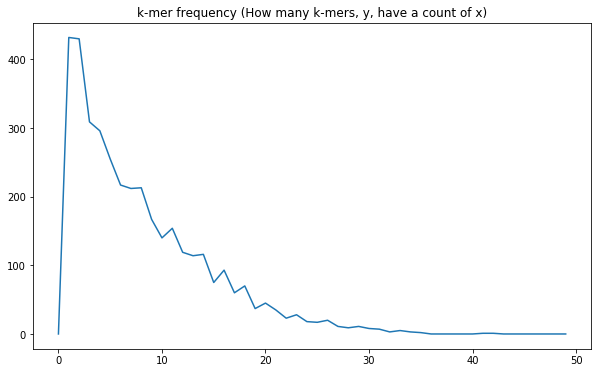

In [12]:
import matplotlib
import matplotlib.pyplot as plot
%matplotlib inline

# Compute a histogram of kmer-counts (i.e. how many kmers appear 1 time, 2 times, 3 times ...)
k = 6
maxcount = 50
kmers = kmerCounts(seq[0], k)
hist = [0 for i in range(maxcount)]
for kmer in kmers:
    count = kmers[kmer]
    if (count < maxcount):
        hist[count] += 1

fig = plot.figure(figsize=(10,6))
plot.title("k-mer frequency (How many k-mers, y, have a count of x)")
plot.plot([i for i in range(maxcount)], hist)
plot.show()

In [13]:
print(hist)

[0, 432, 430, 309, 296, 255, 217, 212, 213, 167, 140, 154, 119, 114, 116, 75, 93, 60, 70, 37, 45, 35, 23, 28, 18, 17, 20, 11, 9, 11, 8, 7, 3, 5, 3, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


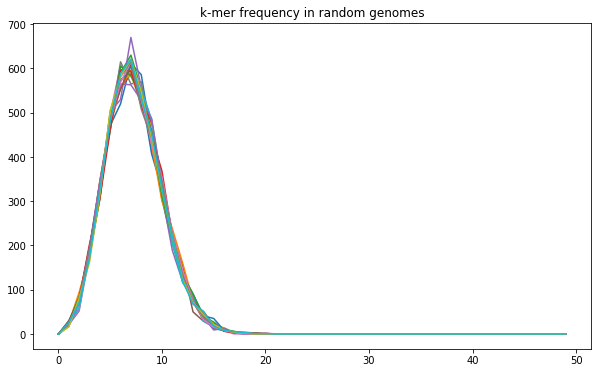

In [14]:
import random

fig = plot.figure(figsize=(10,6))
plot.title("k-mer frequency in random genomes")
for j in range(20):
    # Make a fake genome of random nucleotides
    fake = '+' + ''.join(random.choices("ACGT", k=len(seq[0])-1))
    k = 6
    maxcount = 50
    kmers = kmerCounts(fake, k)
    hist = [0 for i in range(maxcount)]
    for kmer in kmers:
        count = kmers[kmer]
        if (count < maxcount):
            hist[count] += 1
        if (count > 25):
            print(kmer, count)
    plot.plot([i for i in range(maxcount)], hist)
plot.show()

## Back to our Virus
Next we extract the Spike gene to look for patterns.

In [15]:
gene = {
    "ORF1a": (266, 13484),
    "ORF1ab": (266, 21556),
    "S": (21563, 25385),
    "ORF3a": (25393, 26221),
    "E": (26245, 26473),
    "M": (26523, 27192),
    "ORF6": (27202, 27388),
    "ORF7a" : (27394, 27760),
    "ORF7b": (27756, 27888),
    "ORF8": (27894, 28260),
    "N": (28274, 29534),
    "ORF10": (29558, 29675),
}

start, end = gene['S']    # Spike gene
spike = seq[0][start:end]
print(spike, len(spike))

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [16]:
codon = {  # Maps an RNA triplet of nucelotides to a 1-letter Amino Acid Abbrevation 
    "AAA": 'K', "AAG": 'K', "AAC": 'N', "AAT": 'N',
    "AGA": 'R', "AGG": 'R', "AGC": 'S', "AGT": 'S',
    "ACA": 'T', "ACG": 'T', "ACC": 'T', "ACT": 'T',
    "ATA": 'I', "ATG": 'M', "ATC": 'I', "ATT": 'I',
    "GAA": 'E', "GAG": 'E', "GAC": 'D', "GAT": 'D',
    "GGA": 'G', "GGG": 'G', "GGC": 'G', "GGT": 'G',
    "GCA": 'A', "GCG": 'A', "GCC": 'A', "GCT": 'A',
    "GTA": 'V', "GTG": 'V', "GTC": 'V', "GTT": 'V',
    "CAA": 'Q', "CAG": 'Q', "CAC": 'H', "CAT": 'H',
    "CGA": 'R', "CGG": 'R', "CGC": 'R', "CGT": 'R',
    "CCA": 'P', "CCG": 'P', "CCC": 'P', "CCT": 'P',
    "CTA": 'L', "CTG": 'L', "CTC": 'L', "CTT": 'L',
    "TAA": '*', "TAG": '*', "TAC": 'Y', "TAT": 'Y',
    "TGA": '*', "TGG": 'W', "TGC": 'C', "TGT": 'C',
    "TCA": 'S', "TCG": 'S', "TCC": 'S', "TCT": 'S',
    "TTA": 'L', "TTG": 'L', "TTC": 'F', "TTT": 'F'
}

AminoAcid = { # Maps 1-letter Amino Acid Abbrevations to their full name
    'A': 'Alanine', 'C': 'Cysteine', 'D': 'Aspartic acid', 'E': 'Glutamic acid', 'F': 'Phenylalanine',
    'G': 'Glycine', 'H': 'Histidine', 'I': 'Isoleucine', 'K': 'Lysine', 'L': 'Leucine', 'M': 'Methionine',
    'N': 'Asparagine', 'P': 'Proline', 'Q': 'Glutamine', 'R': 'Arginine', 'S': 'Serine',
    'T': 'Theronine', 'V': 'Valine', 'W': 'Tryptophan', 'Y': 'Tyrosine', '*': 'STOP'
}

In [17]:
peptide = ''.join([codon[spike[i:i+3]] for i in range(0,len(spike),3)])
print(peptide)


MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

## Plotting the Frequencies of Each Amino Acid in the Spike Protein

In [ ]:
def plot_amino_acid_frequencies(filepath, gene_map, gene):
    header, seq = loadFasta(filepath)
    start, end = gene_map[gene]
    spike = seq[0][start:end]

{'M': 14, 'F': 77, 'V': 97, 'L': 108, 'P': 58, 'S': 99, 'Q': 62, 'C': 40, 'N': 88, 'T': 97, 'R': 42, 'A': 79, 'Y': 54, 'G': 82, 'D': 62, 'K': 61, 'H': 17, 'W': 12, 'I': 76, 'E': 48, '*': 1}


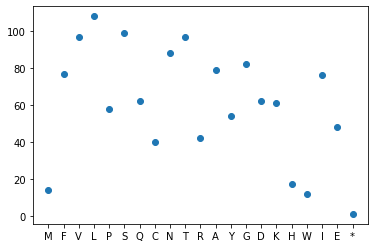

In [18]:
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter

aminoacids = defaultdict(int)

for char in peptide:
    aminoacids[char] += 1

print(dict(aminoacids))

plot.scatter(*zip(*dict(aminoacids).items()))
plot.show()

In [23]:
header2, seq2 = loadFasta("./data/SARS-COV-2Omicron.fasta")

for i in range(len(header2)):
    print(header2[i])
    print(len(seq2[i])-1, "bases", seq2[i][:30], "...", seq2[i][-30:])
    print()

OL672836.1 Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/BEL/rega-20174/2021, complete genome
29684 bases +AGATCTGTTCTCTAAACGAACTTTAAAAT ... CACGCGGAGTACGATCGAGTGTACAGTGAA



## Amino Acid Abbreviations for the Spike Protein in Omicron

In [24]:
omicron = seq2[0]
spike = omicron[21497:25310]
peptide = ''.join([codon[spike[i:i+3]] for i in range(0,len(spike),3)])
print(peptide)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVREPEDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAEVQIDRLITGRLQS